In [3]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import tensorly as tl
import matplotlib.pyplot as plt

In [4]:
from tensorly.decomposition._tucker import partial_tucker

In [40]:
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler

## need to change the company_data_dict.pkl to run for the different sector

In [5]:
with open('./data/final_data/company_data_dict.pkl','rb') as f:
    cmpy_dict = pickle.load(f)

In [6]:
mat = list(cmpy_dict.values())

In [7]:
x = mat[0]

In [8]:
def fill_rows(m,fix_shape = 19):
    n_rows = m.shape[0]
    M = np.zeros(shape=(fix_shape , m.shape[1]))
    M[-n_rows:,:] = m
    for row_num in range(fix_shape-n_rows):
        M[row_num,:] = m[0,:]
    return M

In [9]:
mat = [fill_rows(i) for i in mat]

Consolidation

In [10]:
## consildating the matrices off all companies
mat = np.dstack(mat)
mat = mat.transpose(2,0,1)


In [11]:
mat[:2,:2,:2]

array([[[ 2.48, 11.64],
        [ 2.2 , 12.08]],

       [[ 1.51, -5.65],
        [ 1.08, -9.3 ]]])

In [40]:
print('initial shape of matrix is :' , mat.shape)

initial shape of matrix is : (96, 19, 59)


# initial shape of matrix is : (96, 19, 59)

Normalization

In [20]:
# Normalization using (19,59) matrices
# Using Abs Max along the direction of (1,2)
x_max = np.abs(mat).max(0)
x_max[x_max==0] = 1 ## replace 0 with 1

x_norm = mat / x_max

In [21]:
print(x_norm.min()  , x_norm.max())

-1.0 1.0


### Steps:
1. Taking Median along timestep direction
2. Apply PCA and plot MAE vs no. of components



In [15]:
def mae_error(true_mat , recon_mat):
    val =  np.mean(np.abs(true_mat-recon_mat) )
    return val

In [16]:
def reconstructed_mat(mat , n_comps):
    assert n_comps <= min(mat.shape)
    u,s,vt = np.linalg.svd(mat)
    Sigma = np.zeros_like(mat)
    Sigma[:mat.shape[1] , :mat.shape[1]]  = np.diag(s)
    u = u[:,:n_comps]
    Sigma = Sigma[:n_comps,:]
    rec_mat = u.dot(Sigma.dot(vt))
    return rec_mat
    

In [17]:
def mae_n_comps(mat,n_comps):
    return mae_error(mat , reconstructed_mat(mat , n_comps))

In [18]:
def x_y_plot(mat):
    x_axis = range(1,min(mat.shape)+1)
    y_axis = [mae_n_comps(mat,i) for i in x_axis]
    return x_axis,y_axis

##### Visualization
x_axis , y_axis = x_y_plot(x_norm)

Text(0.5,1,'SVD - Median')

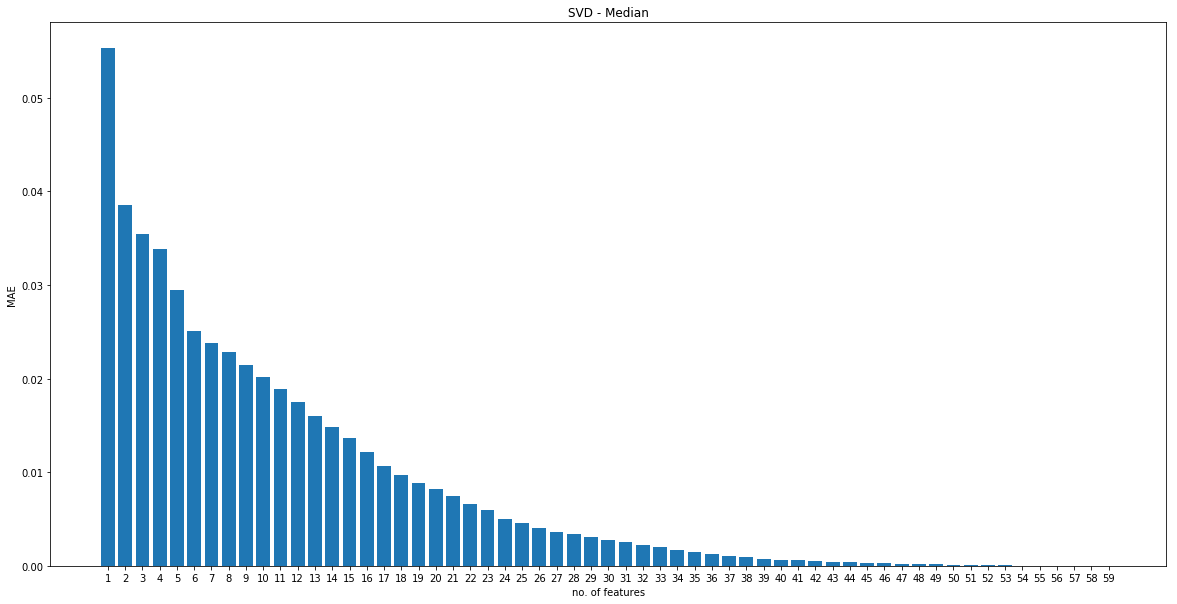

In [17]:
plt.figure(figsize=(20,10))
plt.bar(range(len(y_axis)) , y_axis)
plt.xticks(range(len(y_axis)) ,  x_axis)
plt.xlabel('no. of features')
plt.ylabel('MAE')
plt.title('SVD - Median')

Text(0.5,1,'elbow method')

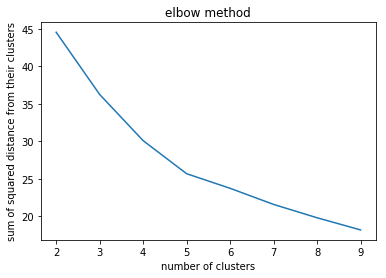

In [225]:
X = x_norm

from sklearn.cluster import KMeans

inertia_list = []
x_axis  = []
for i in range(2,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    val = kmeans.inertia_
    inertia_list.append(val)
    x_axis.append(i)
plt.plot(x_axis,inertia_list)
plt.xlabel('number of clusters')
plt.ylabel('sum of squared distance from their clusters')
plt.title('elbow method')

In [30]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

cmpy_names = list(cmpy_dict.keys())
print(len(cmpy_names))

ll = zip(list(cmpy_names) , list(kmeans.labels_))

from collections import defaultdict

ll_dict = defaultdict(list)

for i,j in ll:
    ll_dict[j] = ll_dict[j]+[i]

print_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in ll_dict.items() ]))
print_df.to_csv('./reports/median_5_clusters.csv',index = False)

NameError: name 'KMeans' is not defined

In [226]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)

cmpy_names = list(cmpy_dict.keys())
print(len(cmpy_names))

ll = zip(list(cmpy_names) , list(kmeans.labels_))

from collections import defaultdict

ll_dict = defaultdict(list)

for i,j in ll:
    ll_dict[j] = ll_dict[j]+[i]

print_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in ll_dict.items() ]))
print_df.to_csv('./reports/median_8_clusters.csv',index = False)

96


#---------------------------------------------
#---------------------------------------------

In [31]:
from tensorly.decomposition import tucker
from tensorly import tucker_to_tensor

In [32]:
core,factors = tucker(x_norm,ranks=10)

In [33]:
tucker_to_tensor(core,factors).shape

(96, 19, 59)

### Tensor SVD

#### Using Tucker Decompostition

In [37]:
def tucker_recon_errors(a ):
    factors_range = range(1,a.shape[-1]+1)
    l_ = []
    
    for i in factors_range:
        core,factors = partial_tucker(a,rank=[i],modes=[2])
        rec = core.dot(factors[0].T)
        l_.append(mae_error(a,rec))
        
    return l_ , list(factors_range)

In [38]:
y_axis , x_axis = tucker_recon_errors(x_norm)

Text(0.5,1,'Tensor SVD')

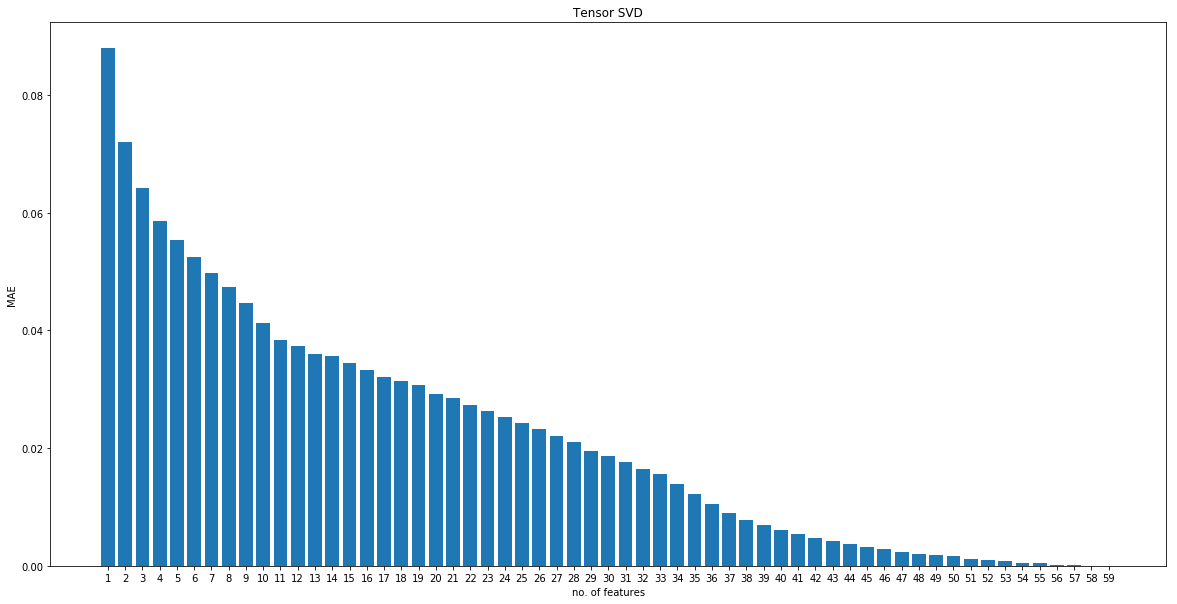

In [29]:
plt.figure(figsize=(20,10))
plt.bar(range(len(y_axis)) , y_axis)
plt.xticks(range(len(y_axis)) ,  x_axis)
plt.xlabel('no. of features')
plt.ylabel('MAE')
plt.title('Tensor SVD')

In [39]:
x_norm.shape

(96, 19, 59)

In [32]:
## pick 20 features from the 
core,factors = partial_tucker(x_norm,modes=[2],rank=[45])

In [33]:
core[0,0,0] , core[1,0,0]

(1.448949215636592, 0.11212521130751639)

In [34]:
core.shape

(96, 19, 45)

In [35]:
## unrolling the timesteps

In [36]:
def time_step_unroll(M):
    M = np.array([i.ravel() for i in M])
    return M

In [37]:
core_unroll = time_step_unroll(core)

In [38]:
core_unroll[0,0] , core_unroll[1,0]

(1.448949215636592, 0.11212521130751639)

In [39]:
core_unroll.max() , core_unroll.min()

(2.688021732431315, -4.038989299223778)

In [40]:
core.shape

(96, 19, 45)

In [43]:
scaler = MinMaxScaler()
core_unroll = scaler.fit_transform(core_unroll)

In [44]:
core_unroll.max() , core_unroll.min()

(1.0000000000000002, 0.0)

Text(0.5,1,'Tensor-SVD elbow method')

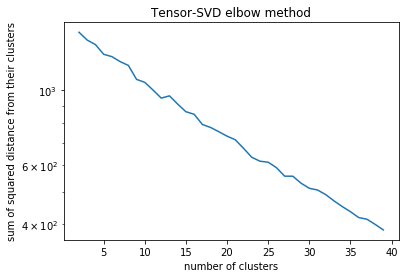

In [87]:
X = core_unroll

inertia_list = []
x_axis  = []
for i in range(2,40):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    val = kmeans.inertia_
    inertia_list.append(val)
    x_axis.append(i)
plt.plot(x_axis,inertia_list)
plt.xlabel('number of clusters')
plt.ylabel('sum of squared distance from their clusters')
plt.yscale('log')
plt.title('Tensor-SVD elbow method')

In [63]:
from sklearn.metrics import silhouette_score

In [64]:
X = core_unroll

In [175]:
def get_f1(n_clus=10):
    l1 = []
    l2 = []
    for _ in range(10):
        kmeans = KMeans(n_clusters=n_clus)
        kmeans.fit(X)
        kmeans.labels_
        l1.append(kmeans.inertia_) ; l2.append(silhouette_score(X,kmeans.labels_))
    print(max(l1)-min(l1) , max(l2)-min(l2))
    return l1,l2

36.56955819464747 0.15697738358206687
37.61125780478642 0.4582304395232166
75.721617073983 0.4087416850969443
71.67395429156909 0.37979800840143146
64.43373802055271 0.3185861569539136
67.50174846016762 0.30943852867627786
74.0253585221983 0.1894400810357942
43.74065436839692 0.2872894042251336
40.873937875059255 0.23298578583823432
44.987682066710704 0.16185809482904157
37.23329160705441 0.18429483921678752
49.05796491761919 0.11880896970134534
54.72755994490501 0.06781948174809874
49.566863361558376 0.1252875988363607
45.700412875364464 0.0763448492678543
31.721960454786654 0.04257452558277385
19.30380314619572 0.03932281280468797
39.66635305666421 0.08445435287669809
44.88720169123849 0.10478115365224844
35.48754874613587 0.03907505008731325
21.778212852969318 0.03949329314806926
24.4488847789396 0.034600928017781675
23.648939066213302 0.04740165996779964
31.61957188796464 0.045448710933395
23.07957923394872 0.030266170724484013
16.236343093278492 0.06433577133759368
24.161131324628

Text(0.5,1,'Tensor-SVD elbow method')

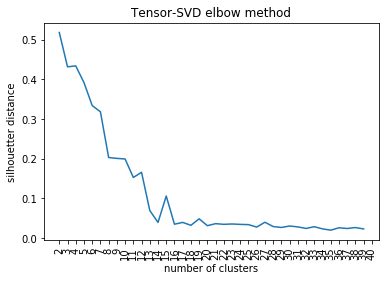

In [252]:
X = core_unroll

from sklearn.cluster import KMeans

sil_list = []
x_axis = []
for i in range(2,40):
    _,v1 = get_f1(i)
    sil_list.append(max(v1))
    x_axis.append(i)
plt.plot(x_axis,sil_list)
plt.xlabel('number of clusters')
plt.ylabel('silhouetter distance')
# plt.yscale('log')
plt.xticks(range(2,41),rotation=90)
plt.title('Tensor-SVD elbow method')

Text(0.5,1,'Tensor-SVD elbow method')

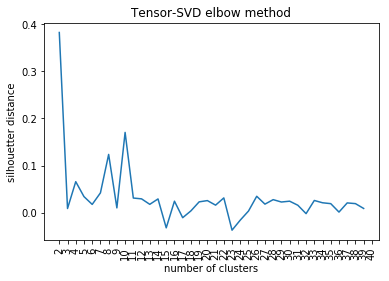

In [90]:
X = core_unroll

from sklearn.cluster import KMeans

sil_list = []
x_axis  = []
for i in range(2,40):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    val = silhouette_score(X  , kmeans.labels_)
    sil_list.append(val)
    x_axis.append(i)
plt.plot(x_axis,sil_list)
plt.xlabel('number of clusters')
plt.ylabel('silhouetter distance')
# plt.yscale('log')
plt.xticks(range(2,41),rotation=90)
plt.title('Tensor-SVD elbow method')

-1.0498221244986778

Text(0.5,1,'Tensor-SVD elbow method')

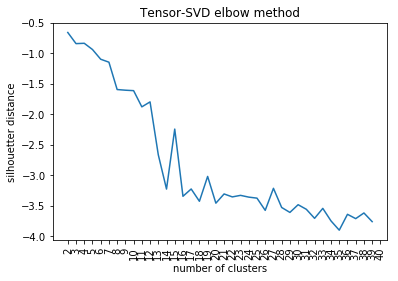

In [256]:
plt.plot(x_axis, [np.log(x) for x in sil_list])
plt.xlabel('number of clusters')
plt.ylabel('silhouetter distance')
# plt.yscale('log')
plt.xticks(range(2,41),rotation=90)
plt.title('Tensor-SVD elbow method')

Text(0.5,1,'Tensor-SVD elbow method')

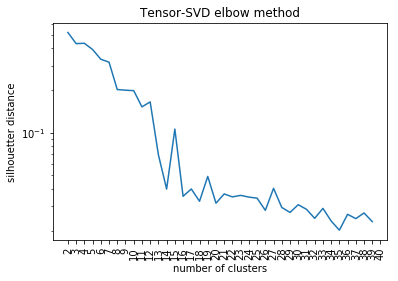

In [260]:
plt.plot(x_axis, sil_list)
plt.xlabel('number of clusters')
plt.ylabel('silhouetter distance')
plt.yscale('log')
plt.xticks(range(2,41),rotation=90)
plt.title('Tensor-SVD elbow method')

Text(0.5,1,'Tensor-SVD elbow method')

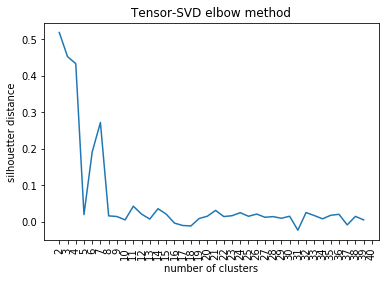

In [79]:
X = core_unroll

from sklearn.cluster import KMeans

sil_list = []
x_axis  = []
for i in range(2,40):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    val = silhouette_score(X  , kmeans.labels_)
    sil_list.append(val)
    x_axis.append(i)
plt.plot(x_axis,sil_list)
plt.xlabel('number of clusters')
plt.ylabel('silhouetter distance')
plt.yscale('log')
plt.xticks(range(2,41),rotation=90)
plt.title('Tensor-SVD elbow method')

Text(0.5,1,'Tensor-SVD elbow method')

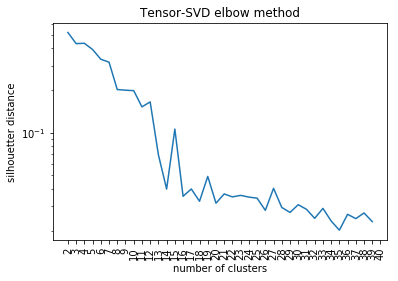

In [253]:
plt.plot(x_axis,sil_list)
plt.xlabel('number of clusters')
plt.ylabel('silhouetter distance')
plt.yscale('log')
plt.xticks(range(2,41),rotation=90)
plt.title('Tensor-SVD elbow method')

In [52]:
for i in range(1,len(inertia_list)):
    print(inertia_list[i]-inertia_list[i-1])

-85.70284536835766
-33.37625781756151
-26.9760593649155
-84.95758550234314
-25.643068983333023
-110.52797510721803
-27.81917729911015
-69.50204218329623
-1.7505382665982552
-36.54027823684328
-43.04286512589624
-17.897308131528803
-37.13699221297111
-58.64207827243854
-29.739284527081963
-12.013177269592802
-40.75130939550684
-26.49547903609789
-22.87948289822498
-37.40820344962026
-30.68265747481371
-7.622575111175138
-23.07511906160562
-1.6275791092481313
-25.469356087420806
-33.658431536173566
-8.629120952712242


In [46]:
X = core_unroll

In [47]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

cmpy_names = list(cmpy_dict.keys())
print(len(cmpy_names))

ll = zip(list(cmpy_names) , list(kmeans.labels_))

from collections import defaultdict

ll_dict = defaultdict(list)

for i,j in ll:
    ll_dict[j] = ll_dict[j]+[i]

print_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in ll_dict.items() ]))
print_df.to_csv('./reports/TensorSVD_10_clusters.csv',index = False)

96


In [266]:
file_name

'./data/15_18/.xlsx'

In [270]:
clus_start = int(input('enter the starting cluster number'))
clus_end = int(input('enter the ending cluster number'))
file_name = str(clus_start)+'_'+str(clus_end)
file_name = os.path.join('./data',file_name+'.xlsx')
writer = pd.ExcelWriter(file_name)
for n_clus in range(clus_start , clus_end+1):
    kmeans = KMeans(n_clusters=n_clus)
    kmeans.fit(X)

    cmpy_names = list(cmpy_dict.keys())
    print(len(cmpy_names))

    ll = zip(list(cmpy_names) , list(kmeans.labels_))

    from collections import defaultdict

    ll_dict = defaultdict(list)

    for i,j in ll:
        ll_dict[j] = ll_dict[j]+[i]

    print_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in ll_dict.items() ]))
    print_df.to_excel(writer,str(n_clus)+'clusters')
writer.save()

96
96
96
96
